In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Uninstall potentially incompatible versions
!pip uninstall -y flwr numpy

# flwr>=1.10.0 is needed for compatibility with NumPy 2.0 (and Python 3.12).
!pip install -q numpy==2.0.0
!pip install -q 'flwr[simulation]>=1.10.0' tensorflow scikit-learn pandas


Mounted at /content/drive
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.1/727.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.1/250.1 kB 18.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydrive2 1.21.3 requires cryptography<44, but you have cryp

In [2]:
import flwr as fl
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Uninstall numpy and related libraries that might have conflicting versions
# It's important to uninstall scipy explicitly to ensure a clean slate.
!pip uninstall -y numpy scikit-learn tensorflow scipy

# Install compatible numpy first
!pip install -q numpy==2.0.0

# Then install scipy, which should be able to resolve to a version compatible with numpy 2.0.0
!pip install -q scipy

# Then install scikit-learn, which depends on scipy and numpy
!pip install -q scikit-learn

# Finally, install tensorflow, which also depends on numpy
!pip install -q tensorflow

# Re-import numpy after re-installation
import numpy as np

Found existing installation: numpy 2.0.0
Uninstalling numpy-2.0.0:
  Successfully uninstalled numpy-2.0.0
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: scipy 1.16.3
Uninstalling scipy-1.16.3:
  Successfully uninstalled scipy-1.16.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pysal 25.7 requires scikit-learn>=1.1, which is not installed.
pysal 25.7 requires scipy>=1.8, which is not installed.
matplotlib-venn 1.1.2 requires scipy, which is not installed.
jax 0.7.2 requires scipy>=1.13, which is not installed.
statsmodels 0.14.6 requires scipy!=1.9.2,>=1.8, which is not installed.
access 1.1.10.post3 requires scipy>=1.14.1, which 

In [3]:
X = pd.read_csv("/content/drive/MyDrive/UNSW_X_preprocessed.csv")
y = pd.read_csv("/content/drive/MyDrive/UNSW_y.csv")

# If y is a DF with one column
if y.shape[1] == 1:
    y = y.iloc[:, 0]

X = X.values.astype("float32")
y = y.values.astype("int32")

print(X.shape, y.shape)


(82332, 18) (82332,)


In [4]:
X_train_all, X_test, y_train_all, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train_all.shape, "Test:", X_test.shape)


Train: (65865, 18) Test: (16467, 18)


In [13]:
import numpy as np

def non_iid_dirichlet_split(X, y, num_clients=10, alpha=0.5):
    """
    Splits dataset into non-IID partitions using Dirichlet distribution.
    alpha < 1  => highly non-IID
    alpha > 1  => more IID
    """
    X = np.array(X)
    y = np.array(y)

    num_classes = len(np.unique(y))
    client_indices = [[] for _ in range(num_clients)]

    # Sample distribution for each class
    label_indices = [np.where(y == i)[0] for i in range(num_classes)]

    for c, indices in enumerate(label_indices):
        np.random.shuffle(indices)
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        proportions = (np.cumsum(proportions) * len(indices)).astype(int)[:-1]
        split_indices = np.split(indices, proportions)

        for client_id, idx in enumerate(split_indices):
            client_indices[client_id].extend(idx)

    # Convert into X, y for each client
    client_data = []
    for i in range(num_clients):
        client_X = X[client_indices[i]]
        client_y = y[client_indices[i]]
        client_data.append((client_X, client_y))

    return client_data

# --------------- RUN SPLIT ----------------
clients = non_iid_dirichlet_split(X, y, num_clients=10, alpha=0.5)

for i, (cx, cy) in enumerate(clients):
    print(f"Client {i}: X shape={cx.shape}, y distribution={np.bincount(cy)}")


Client 0: X shape=(7289, 18), y distribution=[7070  219]
Client 1: X shape=(2807, 18), y distribution=[2691  116]
Client 2: X shape=(4878, 18), y distribution=[4335  543]
Client 3: X shape=(14769, 18), y distribution=[6218 8551]
Client 4: X shape=(6626, 18), y distribution=[4400 2226]
Client 5: X shape=(1751, 18), y distribution=[1086  665]
Client 6: X shape=(3642, 18), y distribution=[ 174 3468]
Client 7: X shape=(20228, 18), y distribution=[ 4496 15732]
Client 8: X shape=(6501, 18), y distribution=[3771 2730]
Client 9: X shape=(13841, 18), y distribution=[ 2759 11082]


In [14]:
def create_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')  # binary classification
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

input_dim = X.shape[1]


In [15]:
class FedProxLoss(tf.keras.losses.Loss):
    def __init__(self, mu, global_weights):
        super().__init__()
        self.mu = mu
        self.global_weights = global_weights

    def call(self, y_true, y_pred):
        ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        prox = 0.0
        for w, w_global in zip(self.model.trainable_variables, self.global_weights):
            prox += tf.reduce_sum(tf.square(w - w_global))
        return ce + (self.mu / 2) * prox

In [16]:
class FedProxClient(fl.client.NumPyClient):
    def __init__(self, X, y, mu=0.01):
        self.X = X
        self.y = y
        self.mu = mu
        self.model = create_model(X.shape[1])

    def get_parameters(self, config=None):
        return self.model.get_weights()

    def set_parameters(self, parameters):
        self.model.set_weights(parameters)
        self.global_weights = [tf.convert_to_tensor(w) for w in parameters]

    def fit(self, parameters, config=None):
        self.set_parameters(parameters)

        optimizer = tf.keras.optimizers.Adam(0.001)

        for epoch in range(10):
            with tf.GradientTape() as tape:
                logits = self.model(self.X, training=True)
                ce_loss = tf.keras.losses.sparse_categorical_crossentropy(self.y, logits)
                prox_loss = 0.0
                for w, w_global in zip(self.model.trainable_variables, self.global_weights):
                    prox_loss += tf.reduce_sum(tf.square(w - w_global))
                loss = tf.reduce_mean(ce_loss + (self.mu / 2) * prox_loss)

            grads = tape.gradient(loss, self.model.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        return self.get_parameters(), len(self.X), {}

    def evaluate(self, parameters, config=None):
        self.set_parameters(parameters)
        preds = np.argmax(self.model.predict(self.X), axis=1)
        acc = np.mean(preds == self.y)
        return 0.0, len(self.X), {"accuracy": acc}

In [17]:
best_acc = 0
patience = 2
wait = 0

In [18]:
def global_evaluate(server_round, parameters, config):
    global best_acc, wait

    model = create_model(X_test.shape[1])
    model.set_weights(parameters)
    loss, acc = model.evaluate(X_test, y_test, verbose=0)

    if acc > best_acc:
        best_acc = acc
        wait = 0
    else:
        wait += 1

    if wait >= patience:
        print("🛑 Early stopping triggered at round", server_round)
        raise StopIteration

    return loss, {"accuracy": acc}

In [19]:
NUM_CLIENTS = 10
strategy = fl.server.strategy.FedProx(
    proximal_mu=0.01,  # proximal strength, required by FedProx strategy
    min_fit_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    fraction_fit=1.0,
    evaluate_fn=global_evaluate
)

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate_round(server_round, parameters, config):
    model = create_model(X_test.shape[1])
    model.set_weights(parameters)

    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n Round {server_round} Results")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1-score  : {f1:.4f}")

    return 0.0, {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }


In [27]:
def client_fn(cid):
    cid = int(cid)
    return FedProxClient(*clients[cid], mu=0.01)

history = fl.simulation.start_simulation(

    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=20),
    strategy=strategy
)

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=20, no round_timeout
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2026-01-02 18:16:58,619	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 9216878183.0, 'node:172.28.0.12': 1.0, 'object_s

🛑 Early stopping triggered at round 1


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


RuntimeError: Simulation crashed.

In [45]:
global_model = create_model(X.shape[1])
global_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

# Load last round weights manually if needed
preds = np.argmax(global_model.predict(X), axis=1)
print(classification_report(y, preds))

2573/2573 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
              precision    recall  f1-score   support

           0       0.11      0.07      0.08     37000
           1       0.41      0.54      0.47     45332

    accuracy                           0.33     82332
   macro avg       0.26      0.30      0.28     82332
weighted avg       0.28      0.33      0.29     82332



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pred_probs = global_model.predict(X_test)
preds = np.argmax(pred_probs, axis=1)

print(classification_report(y_test, preds, digits=4))

acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds, zero_division=0)
rec = recall_score(y_test, preds, zero_division=0)
f1 = f1_score(y_test, preds, zero_division=0)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1:", f1)

515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0     0.8765    0.2103    0.3392      7390
           1     0.6028    0.9759    0.7453      9077

    accuracy                         0.6323     16467
   macro avg     0.7397    0.5931    0.5422     16467
weighted avg     0.7256    0.6323    0.5630     16467

Accuracy: 0.6322948928159349
Precision: 0.6028310875187152
Recall: 0.9758730858213066
F1: 0.7452778595767953


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [24]:
results_df = pd.DataFrame(X_test, columns=[f"f{i}" for i in range(X_test.shape[1])])
results_df["true"] = y_test
results_df["pred"] = preds
results_df["action"] = results_df["pred"].apply(lambda x: "BLOCK" if x == 1 else "ALLOW")

blocked = results_df[results_df["action"] == "BLOCK"]
blocked_path = "/content/drive/MyDrive/UNSW_blocked_predictions_FL2.csv"
blocked.to_csv(blocked_path, index=False)

print(f"Blocked flows saved to: {blocked_path}")
print("Total blocked:", len(blocked))
print("True attacks blocked:", sum((results_df["true"]==1) & (results_df["action"]=="BLOCK")))
print("False blocks:", sum((results_df["true"]==0) & (results_df["action"]=="BLOCK")))


Blocked flows saved to: /content/drive/MyDrive/UNSW_blocked_predictions_FL2.csv
Total blocked: 14694
True attacks blocked: 8858
False blocks: 5836


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [25]:
!pip install seaborn matplotlib scikit-learn


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import numpy as np

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


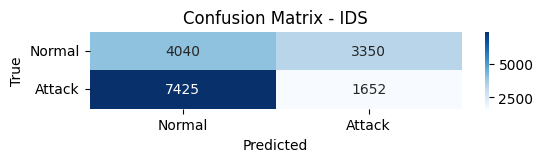

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [33]:
pred_probs_test = global_model.predict(X_test)
preds_test = np.argmax(pred_probs_test, axis=1)

cm = confusion_matrix(y_test, preds_test)

plt.figure(figsize=(6,1))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Attack"],
            yticklabels=["Normal", "Attack"])
plt.title("Confusion Matrix - IDS")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


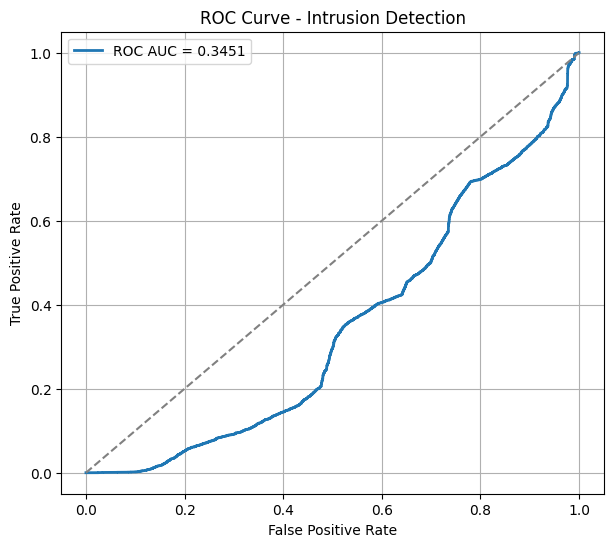

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [31]:
pred_probs = global_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, pred_probs[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, lw=2, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Intrusion Detection")
plt.legend()
plt.grid(True)
plt.show()